In [1]:
import random
# Reproducibility
random.seed(12345)

print(random.randint(0,10),random.randint(0,10),random.randint(0,10))

6 0 4


In [2]:
# Number of data
N = 1000

# String on L digits from 1 to 9
L = 6
C0 = 8
C1 = 9

Cmin = 1
Cmax = 9

y = [None] * N
x = [[None] * L for j in range(N)]

In [3]:
for i in range(N):
    y[i] = int(random.randint(0,3)==0)
    if y[i]:
        j0 = random.randint(0,L-1)
        j1 = (j0+2)%L
    ok = True
    while ok:
        for j in range(L):
            n = random.randint(Cmin,Cmax)
            if y[i]:
                if j==j0:
                    n = C0
                elif j==j1:
                    n=C1
            x[i][j] = n
        ok = False 
        if y[i]==0:
            for j0 in range(L):
                j1 = (j0+2)%L
                if x[j][j0]==C0 and x[i][j1]==C1:
                    ok = True

In [4]:
for i in range(10):
    print(x[i],y[i])

[4, 5, 7, 3, 6, 2] 0
[5, 9, 3, 9, 3, 6] 0
[9, 9, 3, 3, 8, 2] 1
[6, 6, 1, 8, 6, 1] 0
[1, 1, 3, 3, 5, 2] 0
[2, 3, 7, 4, 9, 6] 0
[2, 8, 4, 9, 3, 5] 1
[9, 3, 1, 3, 5, 1] 0
[4, 6, 9, 6, 3, 7] 0
[1, 1, 1, 8, 2, 7] 0


In [5]:
# save space
def compact(v):
    s = 0
    p = 10**(L-1)
    j = 0 
    while j < L:
        s += p*v[j]
        p = int(p/10)
        j += 1
    return s

compact(x[0])

457362

In [6]:
import csv
with open('secretkeys.csv',mode='w') as myfile:
    writer = csv.writer(myfile,delimiter=',')
    for i in range(N):
        writer.writerow([compact(x[i]),y[i]])

In [7]:
import math
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [8]:
D = 9
perc_train = 0.8

fname = 'secretkeys.csv'
dataset = np.loadtxt(fname,delimiter=',',dtype=int)

N = len(dataset)
print(N)
s = dataset[:,0]
y = dataset[:,-1]

L = len(str(s[0]))
print(L)

LD = L*D
print(LD)

for i in range(10):
    print(s[i],y[i])
    
N_train = int(perc_train * N)
print(N,N_train)

1000
6
54
457362 0
593936 0
993382 1
661861 0
113352 0
237496 0
284935 1
931351 0
469637 0
111827 0
1000 800


In [9]:
def expand(S):
    if(len(str(S))!=L):
        print('mismatch!')
        return []
    x = [0] * LD
    p = 10**(L-1)
    j = 0
    while j < L:
        q = int(S/p)
        x[j*D + (q-1)] = 1
        j += 1
        S = S-q*p
        p = int(p/10)
    return x

print(s[0],'-->',expand(s[0]))

457362 --> [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


In [10]:
x_all = [None] * N
for i in range(N):
    x_all[i] = expand(s[i])

print(x_all[0])

(x_train, y_train) = (x_all[0:N_train],y[0:N_train])
(x_test, y_test) = (x_all[N_train:],y[N_train:])

print(len(x_train),len(x_test))

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)


[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
800 200


In [11]:
model = Sequential()
model.add(Dense(LD,input_shape=(LD,),activation='relu'))
model.add(Dense(max(10,int(LD/2)),activation='relu'))
model.add(Dense(max(6,int(LD/4)),activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 54)                2970      
_________________________________________________________________
dense_2 (Dense)              (None, 27)                1485      
_________________________________________________________________
dense_3 (Dense)              (None, 13)                364       
_________________________________________________________________
dropout_1 (Dropout)          (None, 13)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 14        
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
fit = model.fit(x_train, y_train,
                 epochs=80,batch_size=20,
                validation_data=(x_test,y_test))

Train on 800 samples, validate on 200 samples
Epoch 1/80
800/800 [==============================] - 0s 379us/step - loss: 0.6043 - accuracy: 0.7138 - val_loss: 0.5344 - val_accuracy: 0.7550
Epoch 2/80
800/800 [==============================] - 0s 71us/step - loss: 0.5342 - accuracy: 0.7362 - val_loss: 0.4930 - val_accuracy: 0.7600
Epoch 3/80
800/800 [==============================] - 0s 80us/step - loss: 0.4719 - accuracy: 0.7513 - val_loss: 0.4409 - val_accuracy: 0.7550
Epoch 4/80
800/800 [==============================] - 0s 85us/step - loss: 0.4087 - accuracy: 0.7887 - val_loss: 0.3967 - val_accuracy: 0.7950
Epoch 5/80
800/800 [==============================] - 0s 81us/step - loss: 0.3500 - accuracy: 0.8413 - val_loss: 0.3708 - val_accuracy: 0.8150
Epoch 6/80
800/800 [==============================] - 0s 71us/step - loss: 0.3037 - accuracy: 0.8675 - val_loss: 0.3537 - val_accuracy: 0.8250
Epoch 7/80
800/800 [==============================] - 0s 75us/step - loss: 0.2727 - accuracy: 0

800/800 [==============================] - 0s 69us/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.6321 - val_accuracy: 0.8850
Epoch 58/80
800/800 [==============================] - 0s 72us/step - loss: 7.3786e-04 - accuracy: 1.0000 - val_loss: 0.6389 - val_accuracy: 0.8950
Epoch 59/80
800/800 [==============================] - 0s 68us/step - loss: 9.8463e-04 - accuracy: 1.0000 - val_loss: 0.6477 - val_accuracy: 0.8800
Epoch 60/80
800/800 [==============================] - 0s 71us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.6528 - val_accuracy: 0.8900
Epoch 61/80
800/800 [==============================] - 0s 67us/step - loss: 0.0017 - accuracy: 0.9987 - val_loss: 0.6619 - val_accuracy: 0.8850
Epoch 62/80
800/800 [==============================] - 0s 69us/step - loss: 6.5436e-04 - accuracy: 1.0000 - val_loss: 0.6613 - val_accuracy: 0.8900
Epoch 63/80
800/800 [==============================] - 0s 69us/step - loss: 9.9195e-04 - accuracy: 1.0000 - val_loss: 0.6776 - val_accur

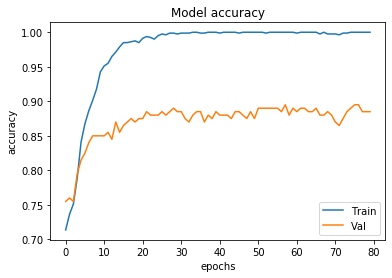

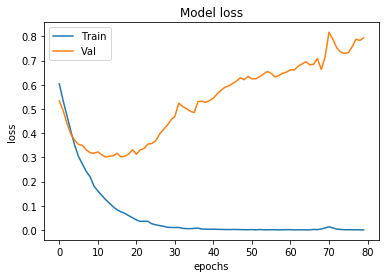

In [14]:
import matplotlib.pyplot as plt

plt.plot(fit.history['accuracy'],label='Train')
plt.plot(fit.history['val_accuracy'],label='Val')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

plt.plot(fit.history['loss'],label='Train')
plt.plot(fit.history['val_loss'],label='Val')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()